In [1]:
import jax, numpyro
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.distributions import (
    Normal, Uniform, TruncatedNormal, Beta, InverseGamma, StudentT, HalfNormal, LogNormal,
    TruncatedDistribution
)
from numpyro.infer.reparam import LocScaleReparam
from corner import corner

from eggman.emulator import Emulator
from eggman.distributions import LogSalpeter
from copy import deepcopy

numpyro.enable_x64()
numpyro.set_platform("cpu")
numpyro.set_host_device_count(10)
rng = random.PRNGKey(0)

In [5]:
from numpyro.handlers import trace, seed, substitute

In [2]:
from eggman.infer import Star

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [2]:
from isochrones.mist.bc import MISTBolometricCorrectionGrid
from jax.scipy.interpolate import RegularGridInterpolator

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [3]:
emulator = Emulator()

In [5]:
bands = ['G', 'BP', 'RP', 'K']
bc_grid = MISTBolometricCorrectionGrid(bands=bands)
bc_grid.df.head()

J         H         K         G        BP  \
Teff   logg [Fe/H] Av                                                       
2500.0 -4.0 -4.0   0.00  1.845781  2.927064  3.436304 -2.181987 -4.652549   
                   0.05  1.831466  2.917990  3.430463 -2.211638 -4.697705   
                   0.10  1.817153  2.908916  3.424623 -2.241241 -4.742843   
                   0.15  1.802841  2.899842  3.418782 -2.270798 -4.787964   
                   0.20  1.788530  2.890769  3.412942 -2.300307 -4.833067   

                               RP  
Teff   logg [Fe/H] Av              
2500.0 -4.0 -4.0   0.00 -0.881256  
                   0.05 -0.909058  
                   0.10 -0.936830  
                   0.15 -0.964572  
                   0.20 -0.992286

In [6]:
teff = bc_grid.df.index.get_level_values('Teff')
logg = bc_grid.df.index.get_level_values('logg')
feh = bc_grid.df.index.get_level_values('[Fe/H]')
av = bc_grid.df.index.get_level_values('Av')

mask = (2e3 <= teff) & (teff <= 2e4) & (2 <= logg) & (logg <= 5) & (-1 <= feh) & (feh <= 0.5) & (av <= 0.5)

In [7]:
points = [bc_grid.df.loc[mask].index.unique(level=name).to_numpy() for name in bc_grid.df.index.names]
shape = [x.shape[0] for x in points]
values = np.reshape(bc_grid.df.loc[mask, bands].to_numpy(), shape + [len(bands),])

In [8]:
bc_interp = RegularGridInterpolator(points, values)

In [9]:
log_zx_sun = np.log10(0.0181)
log_teff_sun = np.log10(5772)
log_g_sun = 4.44
bol_mag_sun = 4.75

In [10]:
bounds = jnp.arange(0.0, 5.0)
widths = jnp.diff(bounds)
new_bounds = jnp.array([0.0, 0.3, 0.6, 0.7, 1.0])
new_widths = jnp.diff(new_bounds)

def generator(a, b, c):
    return lambda x: a + b * (x - c)

funclist = [generator(l, w/nw, nl) for w, nw, l, nl in zip(widths, new_widths, bounds[:-1], new_bounds[:-1])]
    
def evol_phase(x):
    return jnp.piecewise(
        x,
        [(lower <= x) & (x < upper) for lower, upper in zip(new_bounds[:-1], new_bounds[1:])],
        funclist,
    )

(0.0, 4.0)

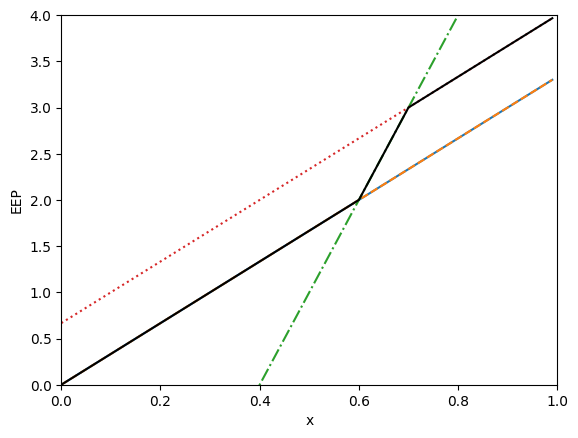

In [11]:
x = np.arange(0, 1, 0.01)

for ls, f in zip(['solid', 'dashed', 'dashdot', 'dotted'], funclist):
    plt.plot(x, f(x), ls=ls)
y = evol_phase(x)

plt.plot(x, y, "k")
plt.xlabel("x")
plt.ylabel("EEP")
plt.xlim(0, 1)
plt.ylim(0, 4)

In [12]:
ln10 = jnp.log(10)

def log_luminosity(log_teff, log_radius):
    return 2 * log_radius + 4 * (log_teff - log_teff_sun)

def log_gravity(log_mass, log_radius):
    return log_mass - 2 * log_radius + log_g_sun

def hydrogen(y, z):
    return 1 - y - z

def metallicity(y, z):    
    return jnp.log10(z / hydrogen(y, z)) - log_zx_sun

def heavy_elements(y, mh):
    return (1 - y) / (10**-(mh + log_zx_sun) + 1)

def bolometric_magnitude(log_lum):
    return bol_mag_sun - 2.5 * log_lum

def absolute_magnitude(bol_mag, bc):
    return bol_mag - bc

def apparent_magnitude(abs_mag, plx):
    return abs_mag - 5 * (jnp.log10(plx) + 1)

class Model:
    def __init__(self, prior=None):
        if prior is None:
            prior = {}
        # Uses lambda to temp fix bug
        self.prior = {
            "x": prior.get("x", Uniform(0.0, 0.999)),
            "ln_mass": prior.get("ln_mass", LogSalpeter(jnp.log(0.7), jnp.log(2.3), rate=2.35)),
            "Y": prior.get("Y", Uniform(0.22, 0.32)),
            "M_H": prior.get("M_H", Uniform(-0.9, 0.5)),
            "a_MLT": prior.get("a_MLT", Uniform(1.3, 2.7)),
            "plx": prior.get("plx", LogNormal(jnp.log(0.1), 1.0)),
            "Av": prior.get("Av", HalfNormal(0.1))
        }

    def __call__(self, obs=None, sigma=None):
        
        if obs is None:
            obs = {}
        if sigma is None:
            sigma = {}
        
        prior = deepcopy(self.prior)  # needed to avoid leak issue with truncated distributions
        param = {
            key: numpyro.sample(key, value) for key, value in prior.items()
        }
        
        eep = numpyro.deterministic("EEP", evol_phase(param["x"]))
        mass = numpyro.deterministic("mass", jnp.exp(param["ln_mass"]))

        z = numpyro.deterministic("Z", heavy_elements(param["Y"], param["M_H"]))
        log_z = jnp.log10(z)

        xx = jnp.stack([eep, mass, param["Y"], log_z, param["a_MLT"]], axis=-1)
    #     yy = numpyro.deterministic("emulator", emulator(xx))
        yy = emulator(xx)

        log_lum = numpyro.deterministic("log_lum", log_luminosity(yy[1], yy[2]))
        log_rad = numpyro.deterministic("log_rad", yy[2])
        rad = numpyro.deterministic("rad", 10**log_rad)

        logg = numpyro.deterministic("logg", log_gravity(param["ln_mass"]/ln10, log_rad))
        lum = numpyro.deterministic("lum", 10**log_lum)
        teff = numpyro.deterministic("Teff", 10**yy[1])
        dnu = numpyro.deterministic("Dnu", 10**yy[3])

        distance = numpyro.deterministic("dist", 1/param["plx"])

        xx = jnp.stack([teff, logg, param["M_H"], param["Av"]], axis=-1)
    #     bc = numpyro.deterministic("bol_corr", bc_interp(xx).squeeze())
        bc = bc_interp(xx).squeeze()

        bol_mag = bolometric_magnitude(log_lum)
        abs_mag = absolute_magnitude(bol_mag, bc)
        mag = apparent_magnitude(abs_mag, param["plx"])

        for i, band in enumerate(bands):
            numpyro.deterministic(f"{band}_abs", abs_mag[i])
            mu = numpyro.deterministic(band, mag[i])
            if band not in obs:
                continue
            numpyro.sample(
                f"{band}_obs", 
                StudentT(5, mu, sigma.get(band, 2e-3)),
                obs=obs[band],
            )

        log_age = numpyro.deterministic("log_age", yy[0])
        age = numpyro.deterministic("age", 10**log_age)

In [6]:
truths = {
    "x": 0.4,
    "ln_mass": np.log(1.1),
    "Y": 0.28,
    "M_H": 0.0,
    "a_MLT": 2.0,
    "plx": 0.047,
    "Av": 0.01
}

# const = {
#     "mu_M_H": truths["M_H"],
#     "sigma_M_H": 0.1,
#     "mu_plx": truths["plx"],
#     "sigma_over_plx": 5e-4,
#     "mu_Av": truths["Av"],
#     "sigma_over_Av": 0.1,
# }
const = {}
const["M_H"] = {"mu": truths["M_H"], "sigma": 0.1}
const["plx"] = {"mu": truths["plx"], "sigma": 2.35e-5}
const["Av"] = {"mu": truths["Av"], "sigma": 0.005}
# Also need sigmas for observed values.

model = Star()

true_trace = trace(seed(substitute(model, truths), rng)).get_trace(const)
truths = {k: v["value"] for k, v in true_trace.items()}

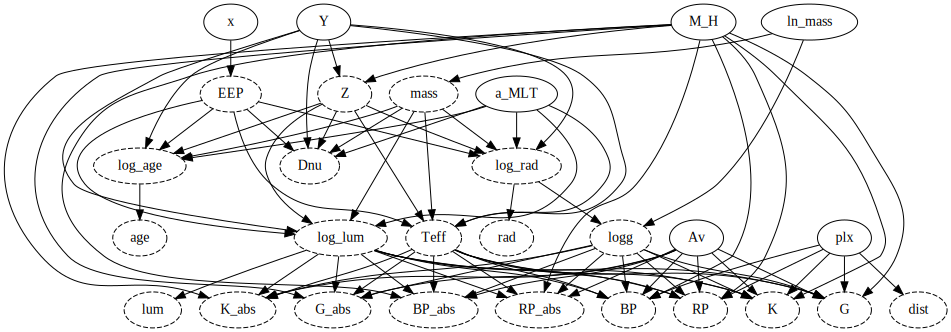

In [7]:
numpyro.render_model(model, model_args=(const,))

In [8]:
rng, key = random.split(rng)
prior_predictive = Predictive(model, num_samples=10000)
prior_samples = prior_predictive(key, const)

In [9]:
data = az.from_numpyro(prior=prior_samples)
data

Inference data with groups:
	> prior

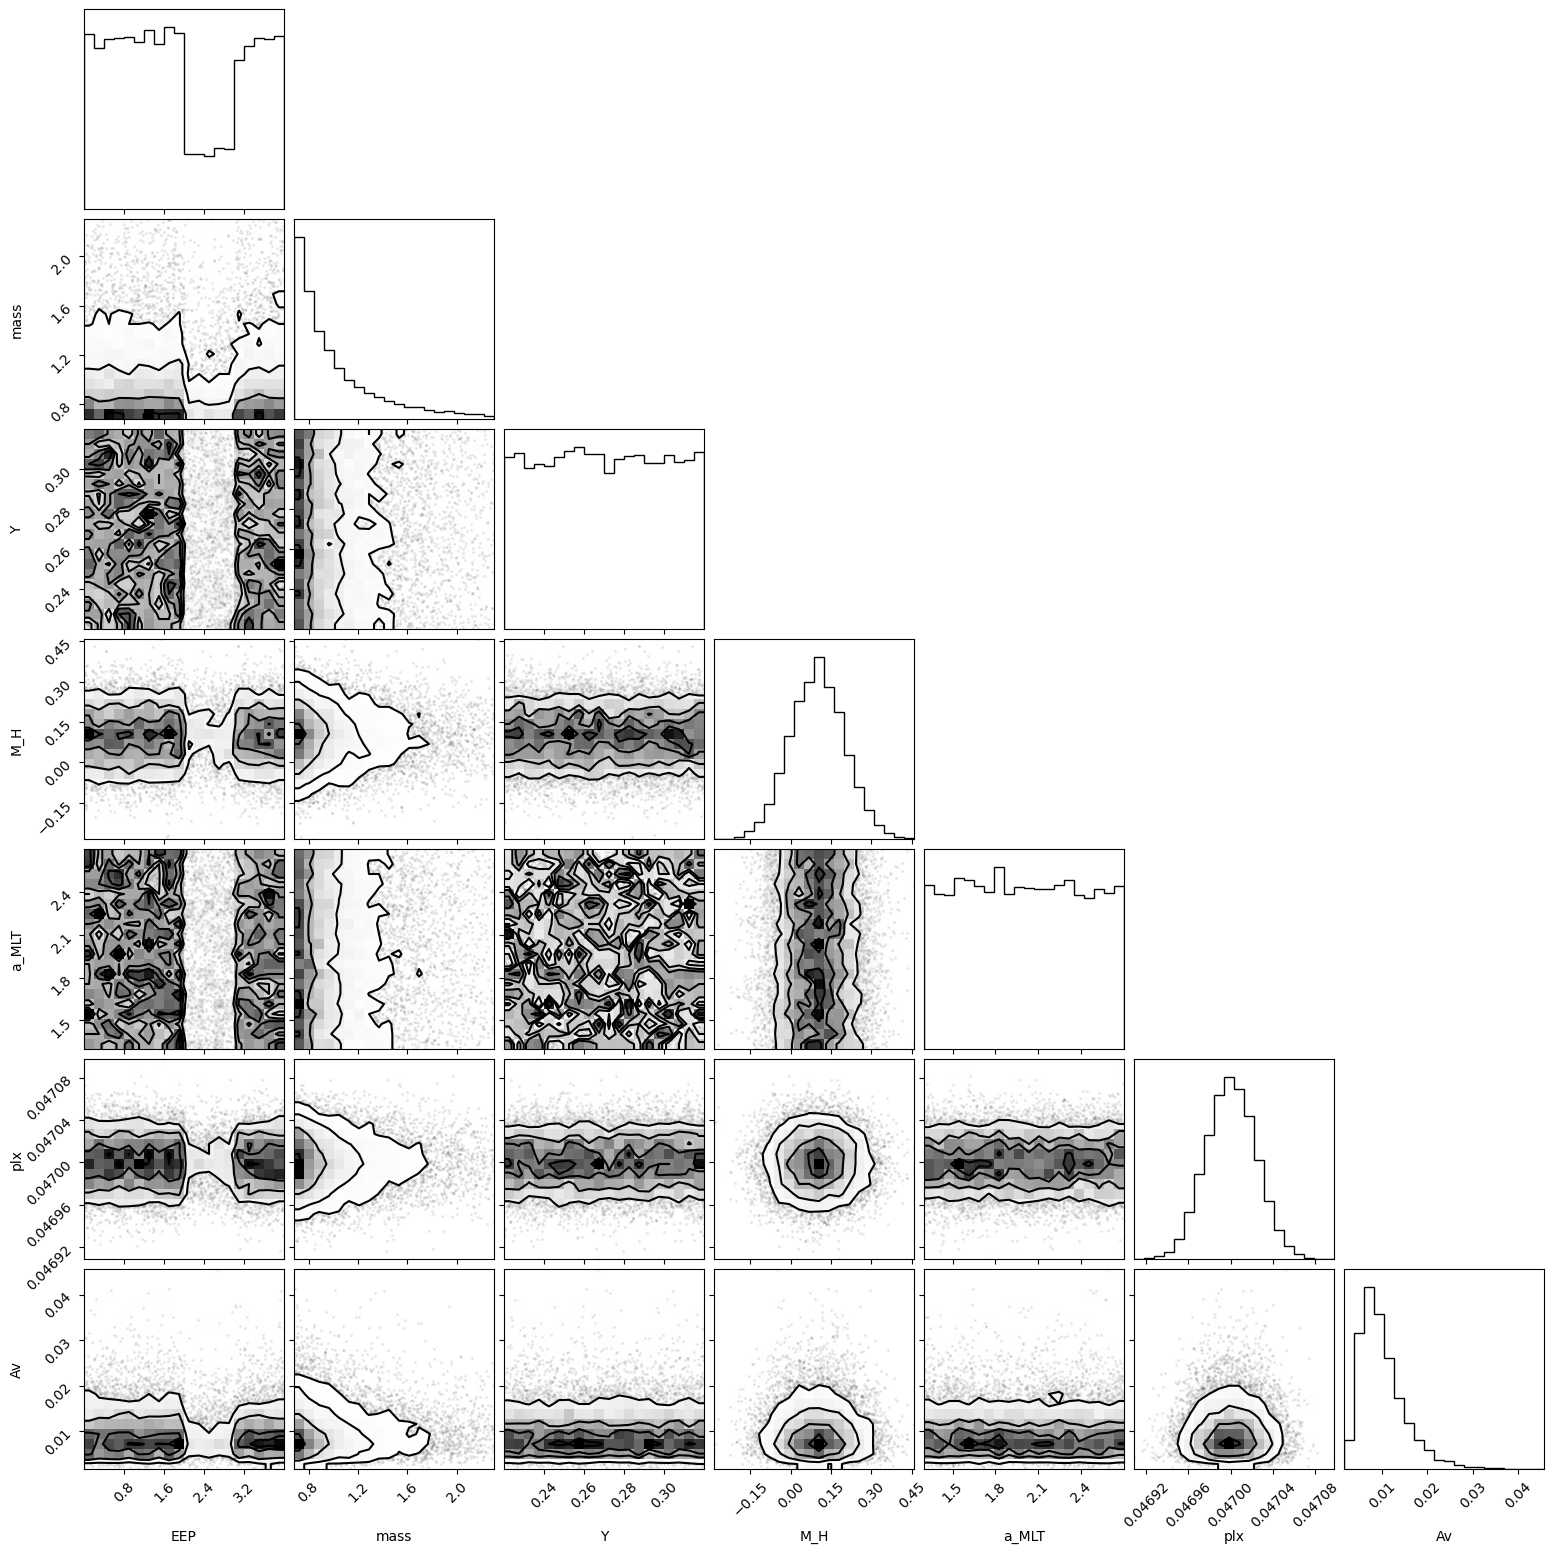

In [10]:
fig = corner(data, group="prior", var_names=["EEP", "mass", "Y", "M_H", "a_MLT", "plx", "Av"])

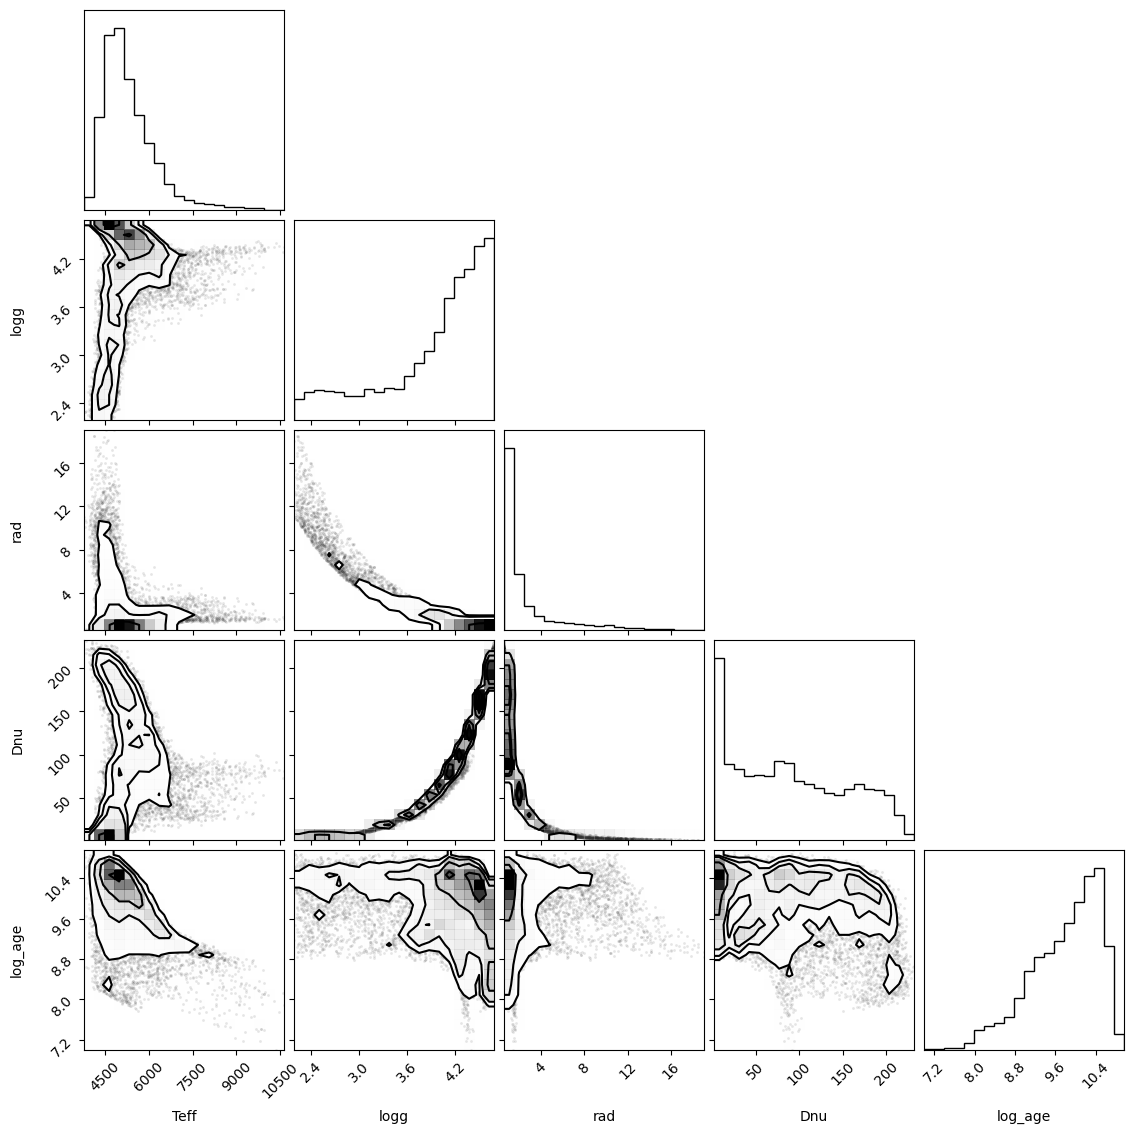

In [15]:
fig = corner(data, group="prior", var_names=["Teff", "logg", "rad", "Dnu", "log_age"])

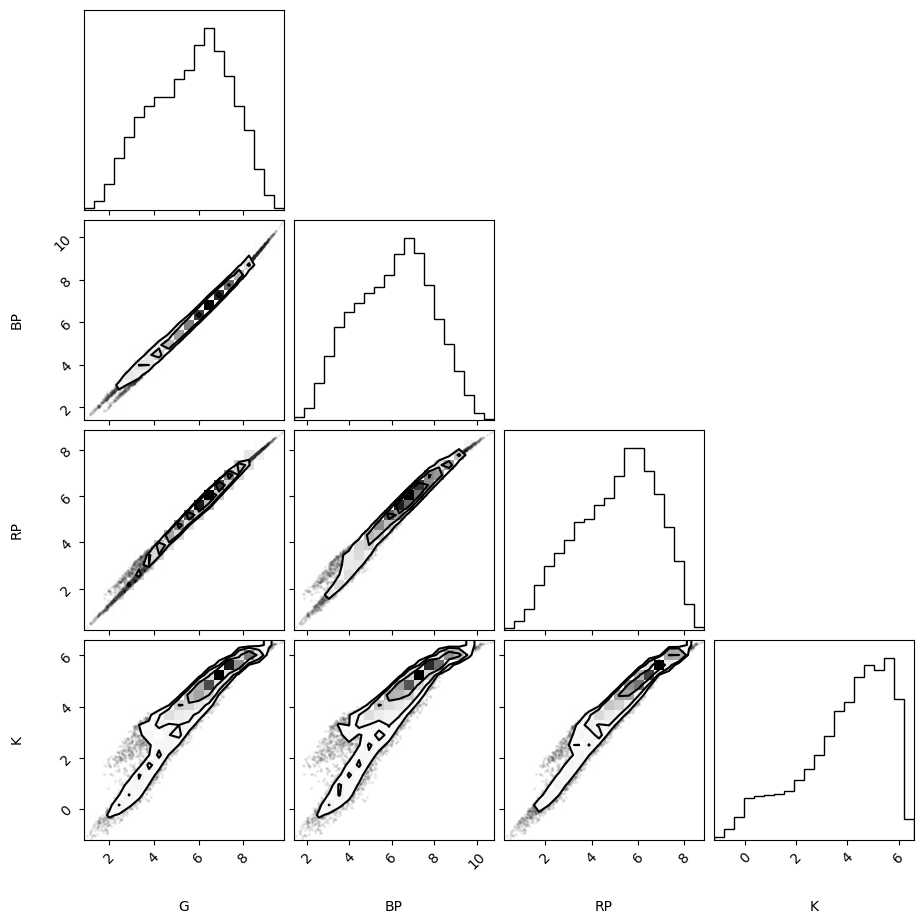

In [16]:
fig = corner(data, group="prior", var_names=model.bands)

In [17]:
from numpyro.handlers import substitute, seed, trace

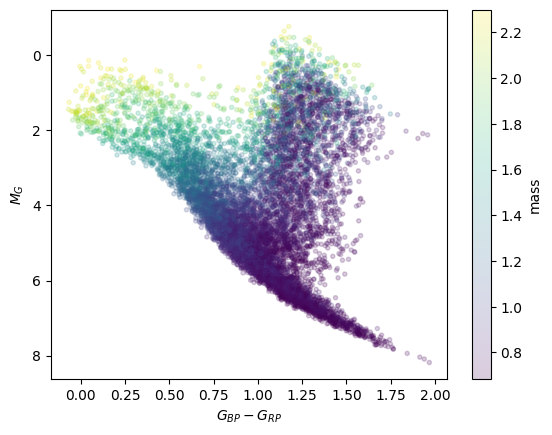

In [18]:
fig, ax = plt.subplots()
ckey = "mass"

s = ax.scatter(prior_samples["BP"]-prior_samples["RP"], prior_samples["G_abs"], 
               c=prior_samples[ckey], marker=".", alpha=0.2)
ax.invert_yaxis()
ax.set_xlabel("$G_{BP} - G_{RP}$")
ax.set_ylabel("$M_G$")
fig.colorbar(s, label=ckey)

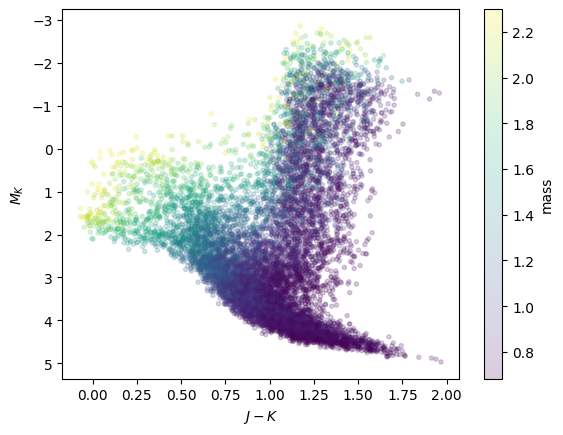

In [21]:
fig, ax = plt.subplots()
ckey = "mass"

s = ax.scatter(prior_samples["BP"]-prior_samples["RP"], prior_samples["K_abs"], 
               c=prior_samples[ckey], marker=".", alpha=0.2)
ax.invert_yaxis()
ax.set_xlabel("$J - K$")
ax.set_ylabel("$M_K$")
fig.colorbar(s, label=ckey)

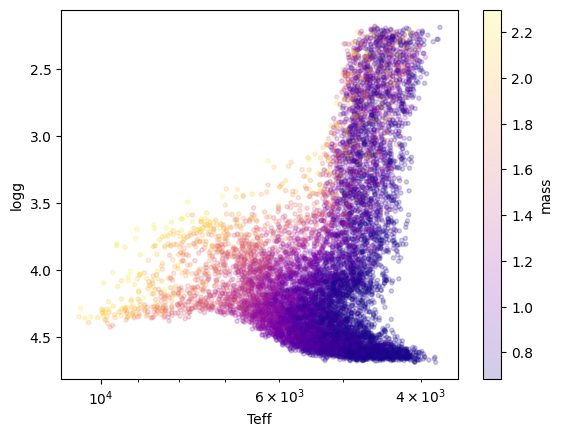

In [22]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "logg"
ckey = "mass"
cmap = "plasma"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], cmap=cmap, marker=".", alpha=0.2)
# ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.invert_yaxis()

ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

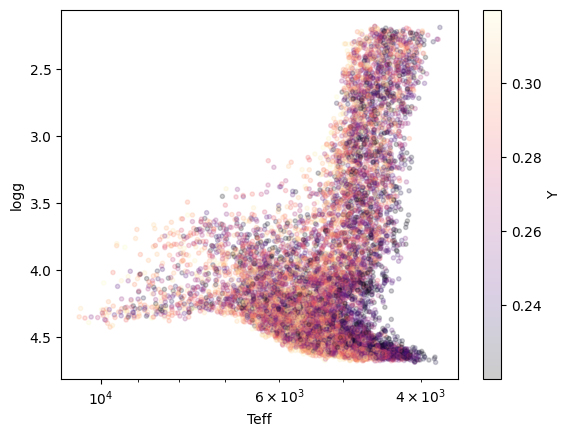

In [23]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "logg"
ckey = "Y"
cmap = "magma"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], cmap=cmap, marker=".", alpha=0.2)
# ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.invert_yaxis()

ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

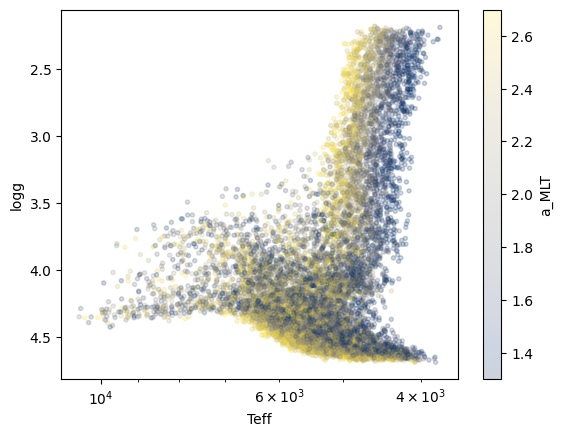

In [24]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "logg"
ckey = "a_MLT"
cmap = "cividis"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], cmap=cmap, marker=".", alpha=0.2)
# ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.invert_yaxis()

ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

In [26]:
nuts = NUTS(model, 
            init_strategy=numpyro.infer.init_to_median,
            dense_mass=[("Y", "a_MLT")],
            )
mcmc = MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=10)

It is very important that luminosity uncertainty is reasonable. If too low, struggles to sample. This could be emulator noise.

In [28]:
obs = {band: truths[band] for band in model.bands}
const.update({band: {"sigma": 3e-3} for band in model.bands})

In [29]:
rng, key = random.split(rng)
mcmc.run(
    key, const, obs=obs,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [30]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        Av      0.01      0.00      0.01      0.00      0.02   5633.11      1.00
       M_H      0.03      0.06      0.04     -0.07      0.13   4399.39      1.00
         Y      0.27      0.03      0.27      0.23      0.32   2749.70      1.00
     a_MLT      2.00      0.41      2.00      1.33      2.58   1515.54      1.01
   ln_mass      0.14      0.08      0.14      0.02      0.28   1320.15      1.00
       plx      0.05      0.00      0.05      0.05      0.05   8816.57      1.00
         x      0.35      0.13      0.37      0.15      0.54    895.04      1.01

Number of divergences: 0


In [31]:
data += az.from_numpyro(mcmc)
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

In [33]:
rng, key = random.split(rng)
post_predictive = Predictive(model, posterior_samples=mcmc.get_samples())
post_samples = post_predictive(key, const, obs=obs)

In [34]:
data += az.from_numpyro(posterior_predictive=post_samples)
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

In [35]:
az.summary(data, var_names=["mass", "rad", "age"])

/home/alex/miniconda3/envs/numpyro/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


mean            sd        hdi_3%       hdi_97%     mcse_mean  \
mass  1.151000e+00  9.000000e-02  9.970000e-01  1.322000e+00  3.000000e-03   
rad   1.348000e+00  4.000000e-03  1.341000e+00  1.355000e+00  0.000000e+00   
age   3.726802e+09  1.888271e+09  1.158002e+08  6.409030e+09  5.597488e+07   

           mcse_sd  ess_bulk  ess_tail  r_hat  
mass  2.000000e-03    1274.0    1844.0   1.00  
rad   0.000000e+00    6354.0    5105.0   1.00  
age   3.959037e+07    1072.0     971.0   1.01

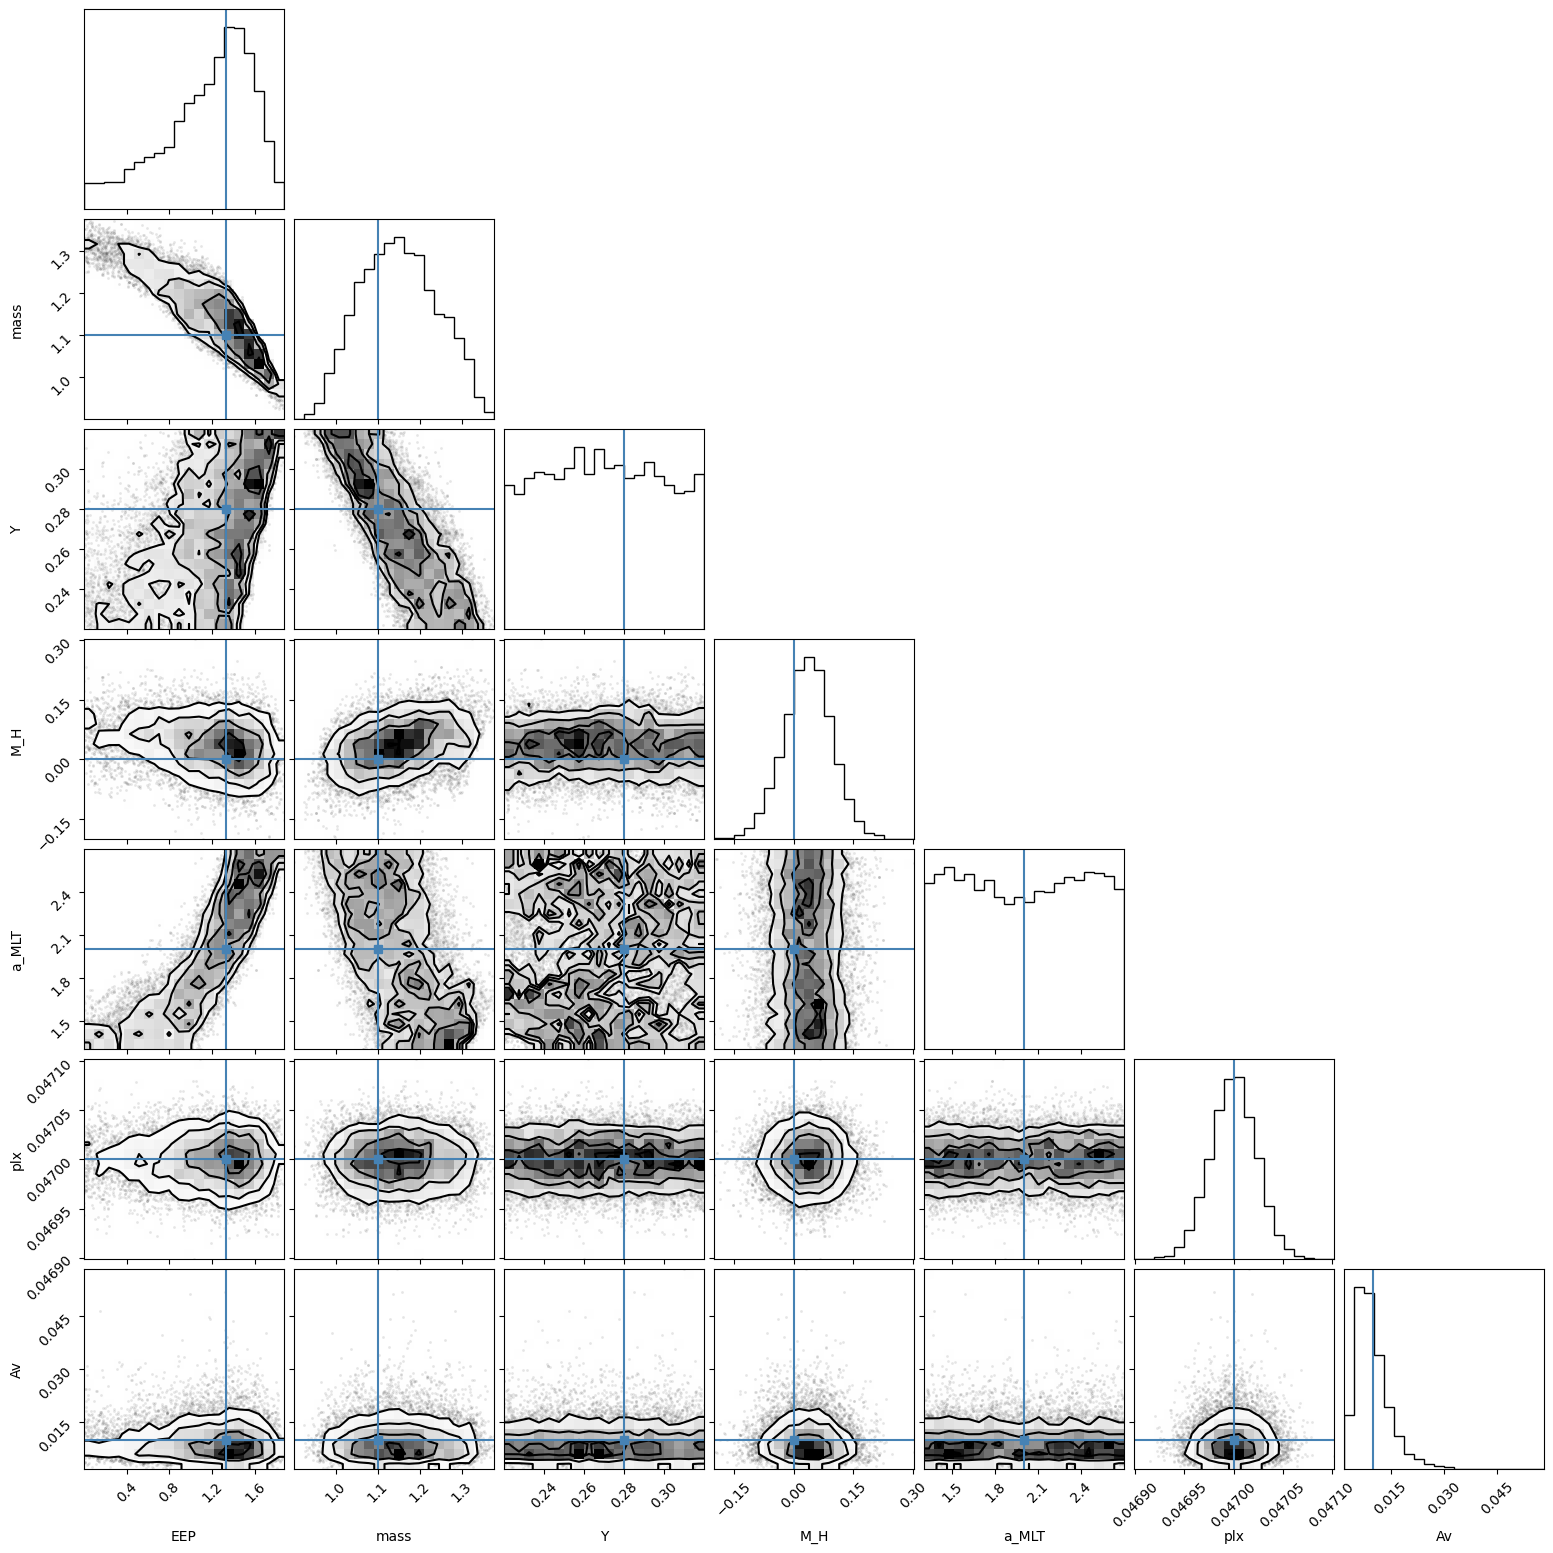

In [36]:
var_names = [
    "EEP", 
    "mass", 
    "Y", 
    "M_H", 
    "a_MLT", 
    "plx",
    "Av",
]

fig = corner(
    data, 
    var_names=var_names, 
    divergences=True,
    truths=truths
)

In [37]:
az.summary(data, var_names=["mass", "rad", "age", "Dnu"])

mean            sd        hdi_3%       hdi_97%     mcse_mean  \
mass  1.151000e+00  9.000000e-02  9.970000e-01  1.322000e+00  3.000000e-03   
rad   1.348000e+00  4.000000e-03  1.341000e+00  1.355000e+00  0.000000e+00   
age   3.726802e+09  1.888271e+09  1.158002e+08  6.409030e+09  5.597488e+07   
Dnu   9.230500e+01  3.433000e+00  8.626200e+01  9.839500e+01  9.000000e-02   

           mcse_sd  ess_bulk  ess_tail  r_hat  
mass  2.000000e-03    1274.0    1844.0   1.00  
rad   0.000000e+00    6354.0    5105.0   1.00  
age   3.959037e+07    1072.0     971.0   1.01  
Dnu   6.400000e-02    1438.0    2399.0   1.00

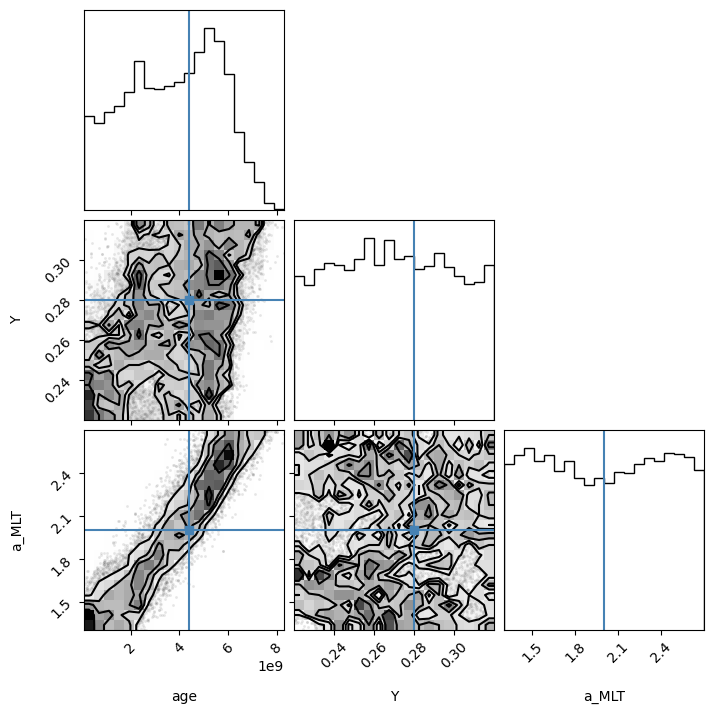

In [38]:
fig = corner(data, var_names=["age", "Y", "a_MLT"], truths=truths)

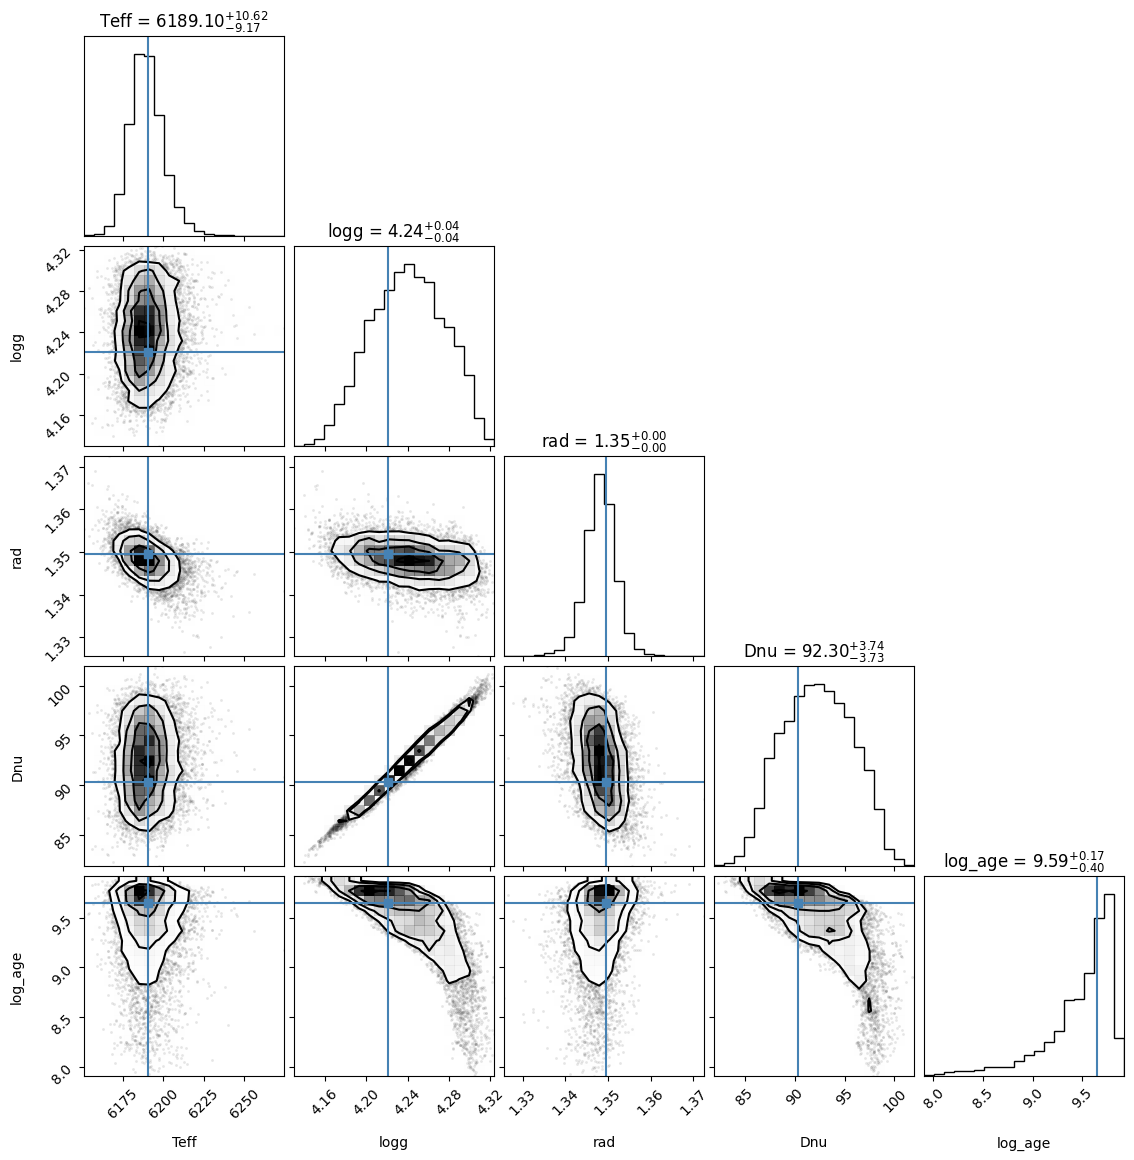

In [39]:
fig = corner(data, var_names=["Teff", "logg", "rad", "Dnu", "log_age"], show_titles=True, truths=truths)

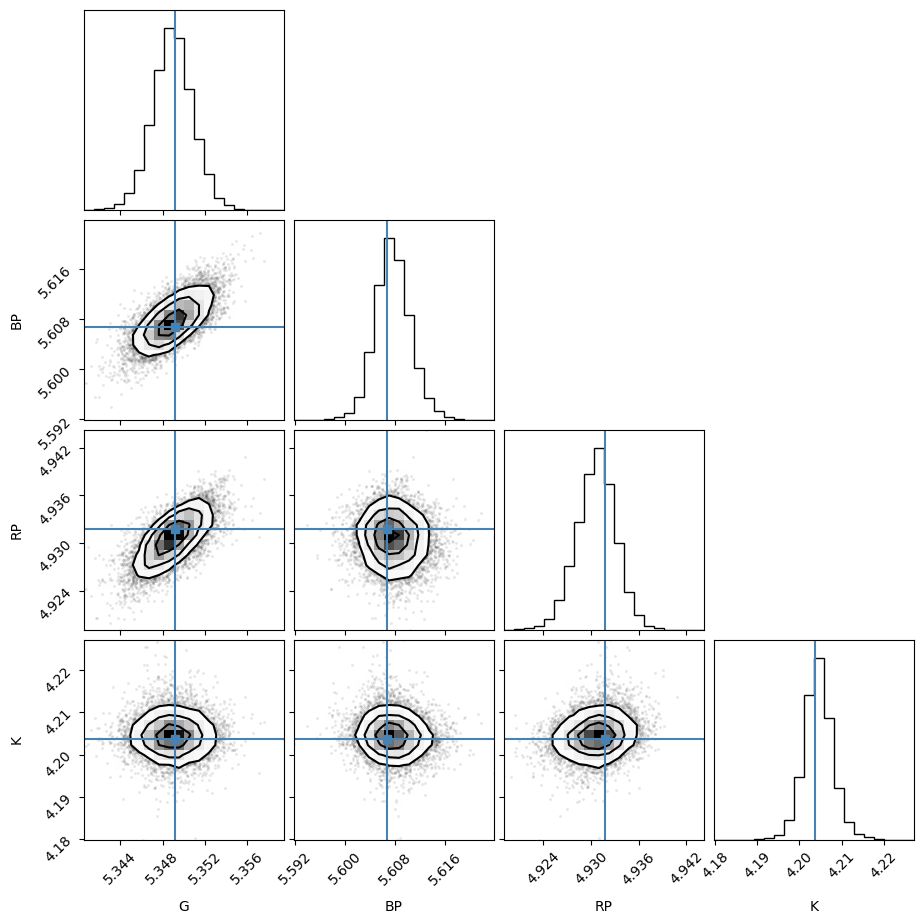

In [41]:
fig = corner(data, var_names=model.bands, truths=truths)